# Chromatin Loop Calling

In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad

from utils.data import DataTree
from utils import out_dire
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dtree = DataTree("../data")

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000})

## Varying axis error

In [5]:
n = 800
err = {"X": 0, "Y": 0, "Z": 50}
np.random.seed(1)

adata = loader.create_adata("chr14")

sub_adata = ad.AnnData(
    obs=np.arange(n, dtype="int64"),
    var=adata.var,
    layers={c: adata[
        adata.obs.sample(n=n, replace=True).index
    ].layers["X"] for c in "XYZ"},
    uns=adata.uns
)
sub_adatan = sub_adata.copy()
for c in "XYZ":
    e = stats.norm.rvs(size=sub_adata.shape, scale=err[c])
    sub_adata.layers[c] -= np.nanmean(sub_adata.layers[c], axis=1)[:,None]
    sub_adata.layers[c] += e

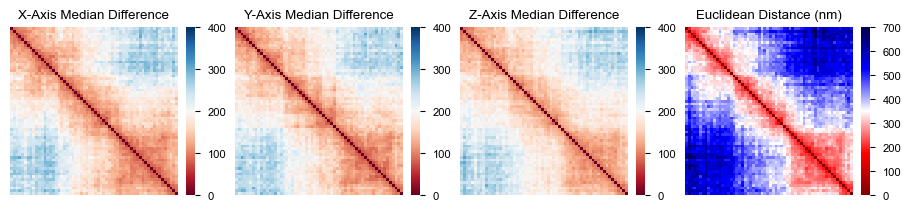

In [6]:
from utils.maps import dist_diff_heatmaps
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
dist_diff_heatmaps(axes, sub_adata, 400, 700)

In [7]:
from utils.utils import filter_loops
plac_ctcf_path = "../data/MAPS/mESC_CTCF_combine_MAPS_call.bedpe"
plac_ctcf = pd.read_csv(plac_ctcf_path, sep="\t")
# Keep cluster summits and singletons
plac_ctcf = plac_ctcf[(plac_ctcf.summit==1)|(plac_ctcf.type=="Singleton")]
plac_ctcf = filter_loops(plac_ctcf, loader)
plac_ctcf.shape

(158, 7)

In [8]:
plac_h3k4me3_path = "../data/MAPS/mESC_H3K4me3_combine_MAPS_call.bedpe"
plac_h3k4me3 = pd.read_csv(plac_h3k4me3_path, sep="\t")
# Keep cluster summits and singletons
plac_h3k4me3 = plac_h3k4me3[(plac_h3k4me3.summit==1)|(plac_h3k4me3.type=="Singleton")]
plac_h3k4me3 = filter_loops(plac_h3k4me3, loader)
plac_h3k4me3.shape

(238, 7)

In [9]:
ctcf_pet_path = dtree["chiapet_mesc", "CTCF", "129S1/SvImJ"]
ctcf_pet = pd.read_csv(ctcf_pet_path, sep="\t", header=None)
ctcf_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
ctcf_pet = ctcf_pet[ctcf_pet["count"] > 5]
ctcf_pet = filter_loops(ctcf_pet, loader)
ctcf_pet.shape

(243, 7)

In [10]:
polr2a_pet_path = dtree["chiapet_mesc", "POLR2A", "129S1/SvImJ"]
polr2a_pet = pd.read_csv(polr2a_pet_path, sep="\t", header=None)
polr2a_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
polr2a_pet = polr2a_pet[polr2a_pet["count"] > 5]
polr2a_pet = filter_loops(polr2a_pet, loader)
polr2a_pet.shape

(297, 7)

In [11]:
hicexpl_path = "../data/bonev_cell_2017/hicexplorer.bedgraph"
edf = pd.read_csv(hicexpl_path, sep="\t", header=None)
edf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "pval"]
edf["c1"] = "chr" + edf["c1"].astype(str)
edf["c2"] = "chr" + edf["c2"].astype(str)
edf = filter_loops(edf, loader)
edf.shape

(55, 7)

In [12]:
fithic2_path = "../data/bonev_cell_2017/output/" \
    + "merged.spline_pass1.res10000.significances.fdr.0.01.bedpe"
fdf = pd.read_csv(fithic2_path, sep="\t", header=None)
fdf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "CC", "pval", "fdr"]
fdf = filter_loops(fdf, loader)
fdf.shape

(213, 7)

In [13]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
common_loops = sf.tl.all_possible_pairs(loader)
for k, v in loop_dfs.items():
    common_loops[k] = sf.tl.loop_overlap(common_loops, v, -1)["overlapped"]
common_loops["count"] = (common_loops.iloc[:,-6:]==3).sum(axis=1)
common_loops = common_loops[common_loops["count"] > 1]
common_loops.to_csv(os.path.join(out_dire, "common_loops.bedpe"), sep="\t", index=False)

In [81]:
len(common_loops)

154

In [27]:
df = sf.tl.loop_overlap(edf, common_loops, -1)
(df["overlapped"]==3).mean()

0.7636363636363637

In [ ]:
loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
res1, res11 = loop.call_loops(sub_adata), loop.call_loops(sub_adatan)
loop = sf.tl.LoopCaller(gap=50e3, ltclass=sf.tl.AxisWiseF)
res2, res21 = loop.call_loops(sub_adata), loop.call_loops(sub_adatan)
mat1 = sf.pp.median_pdist(sub_adata, False)
mat2 = sf.pp.median_pdist(sub_adatan, False)

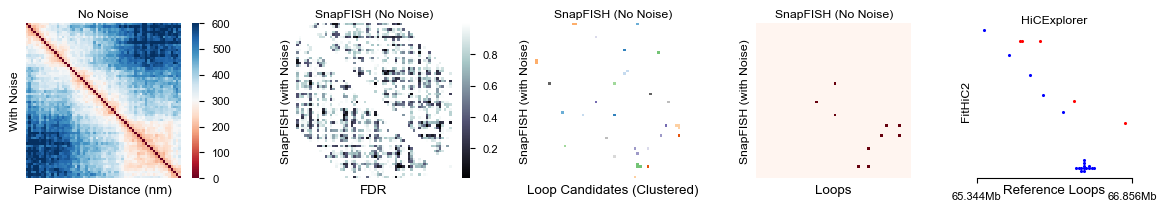

In [197]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
sf.pl.pairwise_heatmap(mat1, mat2, x="No Noise", y="With Noise", vmax=600, ax=axes[0])
axes[0].set_title("Pairwise Distance (nm)", y=-0.15)
sf.pl.pairwise_heatmap(res1["fdr"], res11["fdr"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[1], cmap="bone", 
                       cbar_kws={'ticks': np.linspace(0, 1, 6)})
axes[1].set_title("FDR", y=-0.15)
sf.pl.pairwise_heatmap(res1["label"], res11["label"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
sf.pl.pairwise_heatmap(res1["summit"], res11["summit"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
sf.pl.compare_loops(edf, fdf, sub_adata.uns["Chrom"], ax=axes[4])
axes[4].set_title("Reference Loops", y=-0.15)
axes[4].spines[["top", "right", "left"]].set_visible(False)
axes[4].xaxis.set_label_coords(0.5, 1.05)
axes[4].set(xlabel="HiCExplorer", ylabel="FitHiC2")
fig.savefig(os.path.join(out_dire, "loop_calling_sf1.pdf"), bbox_inches="tight")

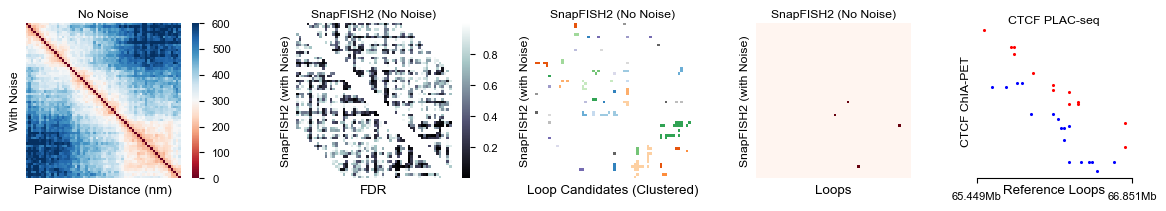

In [195]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
sf.pl.pairwise_heatmap(mat1, mat2, x="No Noise", y="With Noise", vmax=600, ax=axes[0])
axes[0].set_title("Pairwise Distance (nm)", y=-0.15)
sf.pl.pairwise_heatmap(res2["fdr"], res21["fdr"], x="SnapFISH2 (No Noise)", 
                       y="SnapFISH2 (with Noise)", ax=axes[1], cmap="bone", 
                       cbar_kws={'ticks': np.linspace(0, 1, 6)})
axes[1].set_title("FDR", y=-0.15)
sf.pl.pairwise_heatmap(res2["label"], res21["label"], x="SnapFISH2 (No Noise)", 
                       y="SnapFISH2 (with Noise)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
loops1 = np.where(res2["pval"] < 1e-5, res2["summit"], 0)
loops2 = np.where(res21["pval"] < 1e-5, res21["summit"], 0)
sf.pl.pairwise_heatmap(loops1, loops2, x="SnapFISH2 (No Noise)", 
                       y="SnapFISH2 (with Noise)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
sf.pl.compare_loops(plac_ctcf, ctcf_pet, sub_adata.uns["Chrom"], ax=axes[4])
axes[4].set_title("Reference Loops", y=-0.15)
axes[4].spines[["top", "right", "left"]].set_visible(False)
axes[4].xaxis.set_label_coords(0.5, 1.05)
axes[4].set(xlabel="CTCF PLAC-seq", ylabel="CTCF ChIA-PET")
fig.savefig(os.path.join(out_dire, "loop_calling_sf2.pdf"), bbox_inches="tight")

run `AxisWiseTest/scripts/err_rep`

`scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/062025/*.tsv" .`

In [12]:
rep_call_all = pd.read_csv(os.path.join(out_dire, "loop_err_rep_all.tsv"), sep="\t")
rep_call_all = rep_call_all[rep_call_all.final]
grp_obj = rep_call_all.groupby(["method", "err", "rep"], sort=False)
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]

rows = []
for (m, e, r), df in grp_obj:
    # tp = pd.merge(df, common_loops, on=cols, how="inner")
    tp = sf.tl.loop_overlap(df, common_loops)
    tp = tp[tp["overlapped"]==3]
    pr = len(tp)/len(df)
    rc = len(tp)/len(common_loops)
    rows.append([m, e, r, len(df), len(tp), pr, rc])
rows = pd.DataFrame(rows, columns=["method", "err", "rep", "total", "tp", "precision", "recall"])

In [13]:
c1, c2 = sns.palettes.color_palette("dark")[:2]

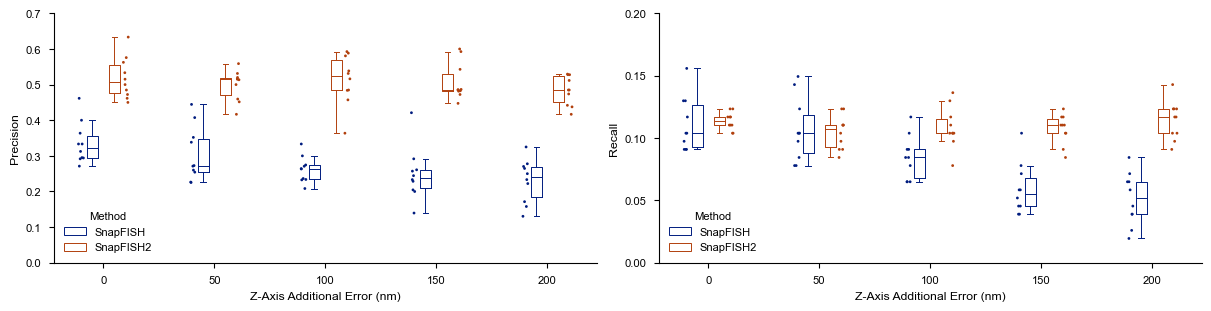

In [375]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
palette = {"SnapFISH": c1, "SnapFISH2": c2}
for ax, y in zip(axes, ["precision", "recall"]):
    sns.boxplot(rows, x="err", y=y, hue="method", native_scale=True, linewidth=.7, 
                fliersize=0, fill=False, gap=1.5, width=.4, palette=palette, ax=ax)
    sns.stripplot(rows, x="err", y=y, hue="method", native_scale=True, s=2, 
                dodge=True, linewidth=0, jitter=.05, palette=palette, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Method", loc="lower left")
    ax.set(xlabel="Z-Axis Additional Error (nm)")
    ax.grid(False)
axes[0].set(ylabel="Precision", ylim=(0, 0.7))
axes[1].set(ylabel="Recall", ylim=(0, 0.2), yticks=[0, .05, 0.1, 0.15, 0.2])
fig.savefig(os.path.join(out_dire, "loop_calling_err.pdf"), bbox_inches="tight")

In [80]:
rows.groupby(["method", "err"]).mean()

rep  total    tp  precision    recall
method    err                                       
SnapFISH  0    4.5   51.3  17.1   0.335639  0.111039
          50   4.5   54.8  16.4   0.305186  0.106494
          100  4.5   50.1  13.0   0.261701  0.084416
          150  4.5   37.0   9.1   0.248116  0.059091
          200  4.5   33.5   7.9   0.230307  0.051299
SnapFISH2 0    4.5   34.0  17.5   0.518868  0.113636
          50   4.5   32.4  16.1   0.498261  0.104545
          100  4.5   32.6  16.7   0.513681  0.108442
          150  4.5   32.7  16.5   0.507633  0.107143
          200  4.5   36.4  17.6   0.483600  0.114286

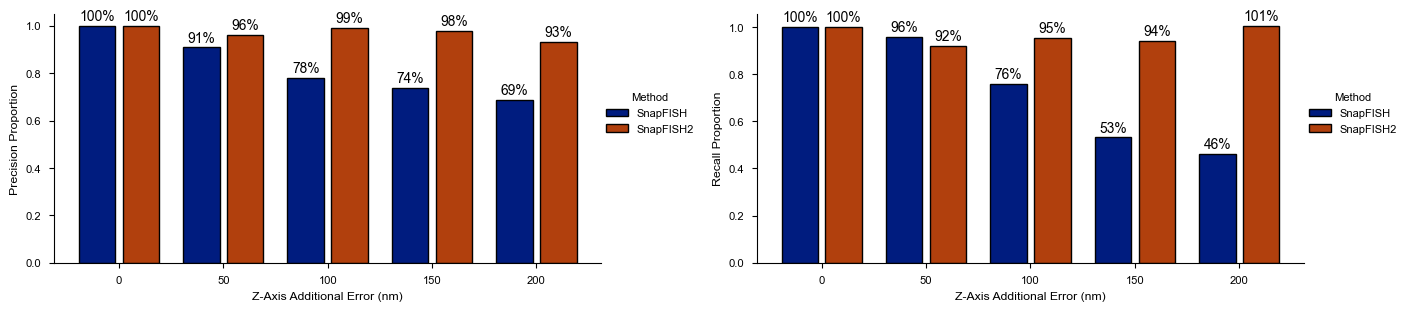

In [79]:
from utils.lines import prc_proportion
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
prc_proportion(axes[0], rows, "precision", palette)
prc_proportion(axes[1], rows, "recall", palette)
fig.savefig(os.path.join(out_dire, "loop_calling_prc.pdf"), bbox_inches="tight")

## Loop calling on original data

In [15]:
res_sf1_path = os.path.join(out_dire, "loop_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1e-5, gap=50e3, ltclass=sf.tl.AxisWiseF)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

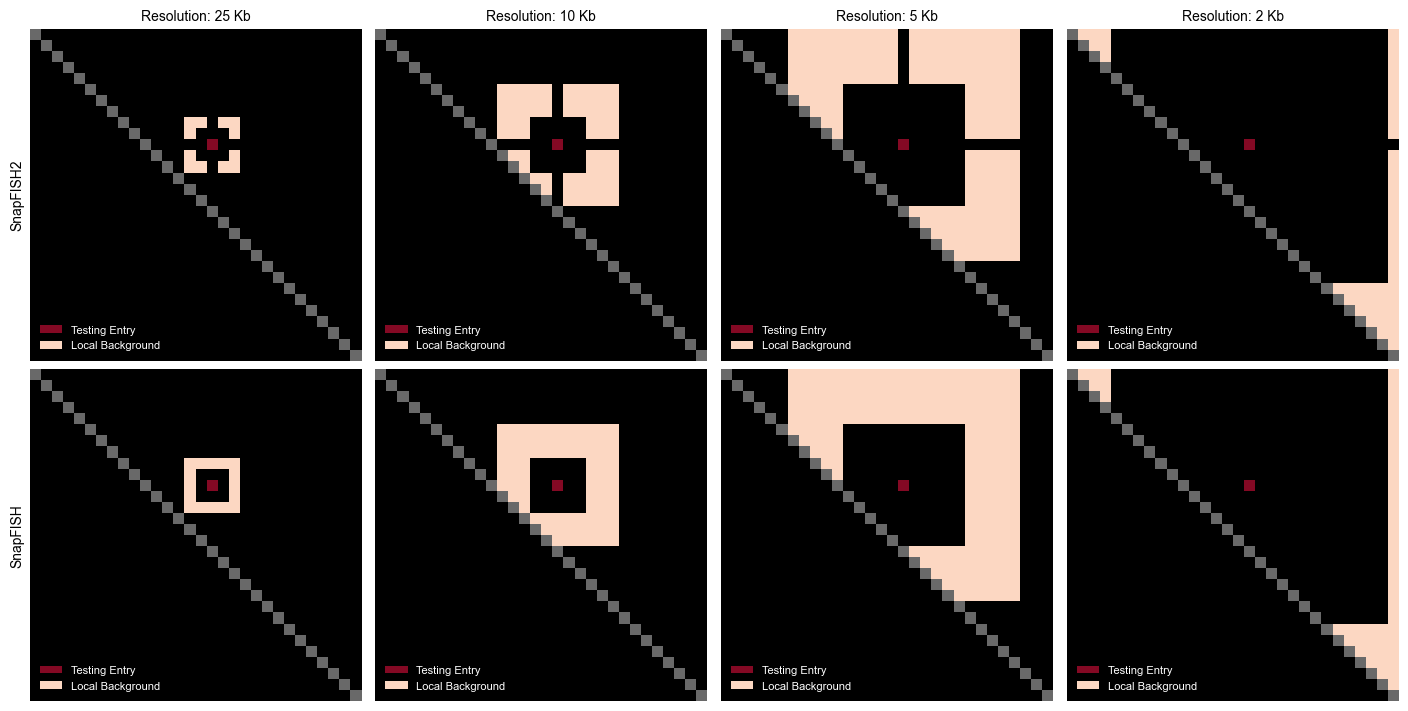

In [209]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, resol in enumerate([25e3, 10e3, 5e3, 2e3]):
    sf.pl.background_model(10, 16, 50e3, sf.tl.AxisWiseF, resol, 30, ax=axes[0,i])
    axes[0,i].set_title(f"Resolution: {int(resol/1e3)} Kb", fontsize=10)
    sf.pl.background_model(10, 16, 50e3, sf.tl.TwoSampleT, resol, 30, ax=axes[1,i])
    # axes[1,i].set_title(f"Resolution: {int(resol/1e3)} Kb", fontsize=10)
    if i == 0:
        axes[0,i].set_ylabel("SnapFISH2", fontsize=10)
        axes[1,i].set_ylabel("SnapFISH", fontsize=10)
fig.savefig(os.path.join(out_dire, "background_model.pdf"), bbox_inches="tight")

In [112]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
test_dfs0, test_dfs1 = [], []
for df in [res_sf1, res_sf2]:
    test_df0 = df[(df.final)&(df["c1"]!="chrX")].copy()
    test_df1 = df[(df.final)&(df["c1"]!="chrX")].copy()
    print(len(test_df0), end="\t")
    for k, v in loop_dfs.items():
        test_df0[k] = sf.tl.loop_overlap(test_df0, v, 0)["overlapped"]
        test_df1[k] = sf.tl.loop_overlap(test_df0, v, -1)["overlapped"]
    test_df0["count"] = (test_df0.iloc[:, -6:] == 3).sum(axis=1)
    test_df1["count"] = (test_df1.iloc[:, -6:] == 3).sum(axis=1)
    test_dfs0.append(test_df0)
    test_dfs1.append(test_df1)

41	23	

In [122]:
overlap_sf1 = sf.tl.loop_overlap(
    res_sf1[(res_sf1.final)&(res_sf1["c1"]!="chrX")], common_loops, 0
)
o = overlap_sf1["overlapped"]==3
print(f"precision: {np.mean(o):.3f}, {np.sum(o)}")
overlap_sf2 = sf.tl.loop_overlap(
    res_sf2[(res_sf2.final)&(res_sf2["c1"]!="chrX")], common_loops, 0
)
o = overlap_sf2["overlapped"]==3
print(f"precision: {np.mean(o):.3f}, {np.sum(o)}")

precision: 0.561, 23
precision: 0.696, 16


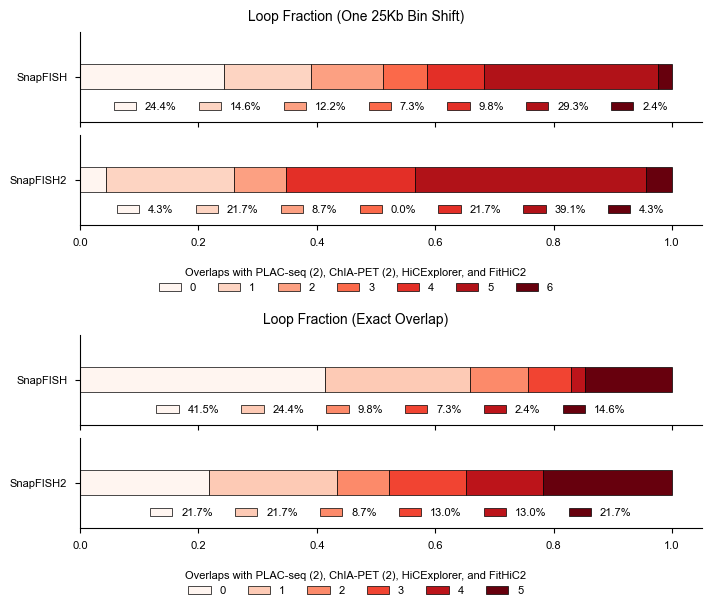

In [120]:
from utils.lines import loop_stack_bar
fig = plt.figure(figsize=(7, 6))
figs = fig.subfigures(2, 1)
loop_stack_bar(figs[0], test_dfs0)
figs[0].suptitle("Loop Fraction (One 25Kb Bin Shift)", fontsize=10)
loop_stack_bar(figs[1], test_dfs1)
figs[1].suptitle("Loop Fraction (Exact Overlap)", fontsize=10)
fig.savefig(os.path.join(out_dire, "loop_frac_stacked_bar.pdf"), bbox_inches="tight")

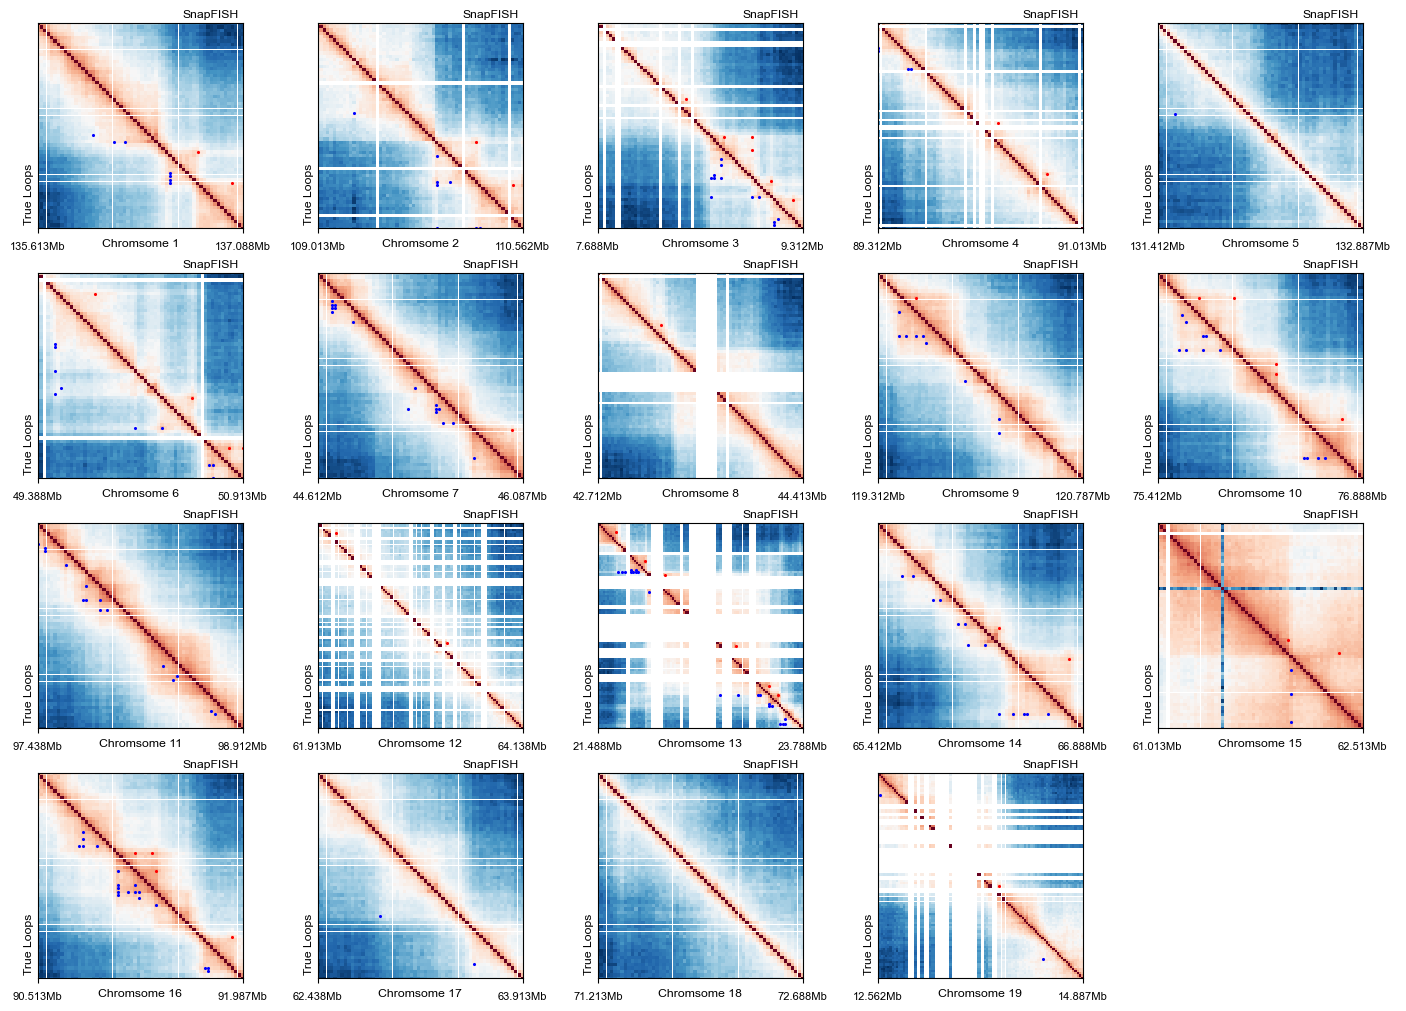

In [28]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i == 19:
        ax.axis("off")
        continue
    adata = loader.create_adata(f"chr{i+1}")
    med_dist = sf.pp.median_pdist(adata, inplace=False)
    d1d = adata.var.mean(axis=1).values
    x, y = list(map(lambda x: x.flatten(), np.meshgrid(d1d, d1d)))
    hm_df = pd.DataFrame({"x": x, "y": y, "dist": med_dist.flatten()})
    sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=ax,
                    palette="RdBu", s=6, marker="s", linewidth=0)
    ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
    sf.pl.compare_loops(res_sf1[res_sf1.final], common_loops, chr_id=f"chr{i+1}", 
                        map1="SnapFISH", map2="True Loops", ax=ax)
    ax.get_legend().remove()
    ax.set(xlabel=f"Chromsome {i+1}")
fig.savefig(os.path.join(out_dire, "loop_sf1_all.pdf"), bbox_inches="tight")

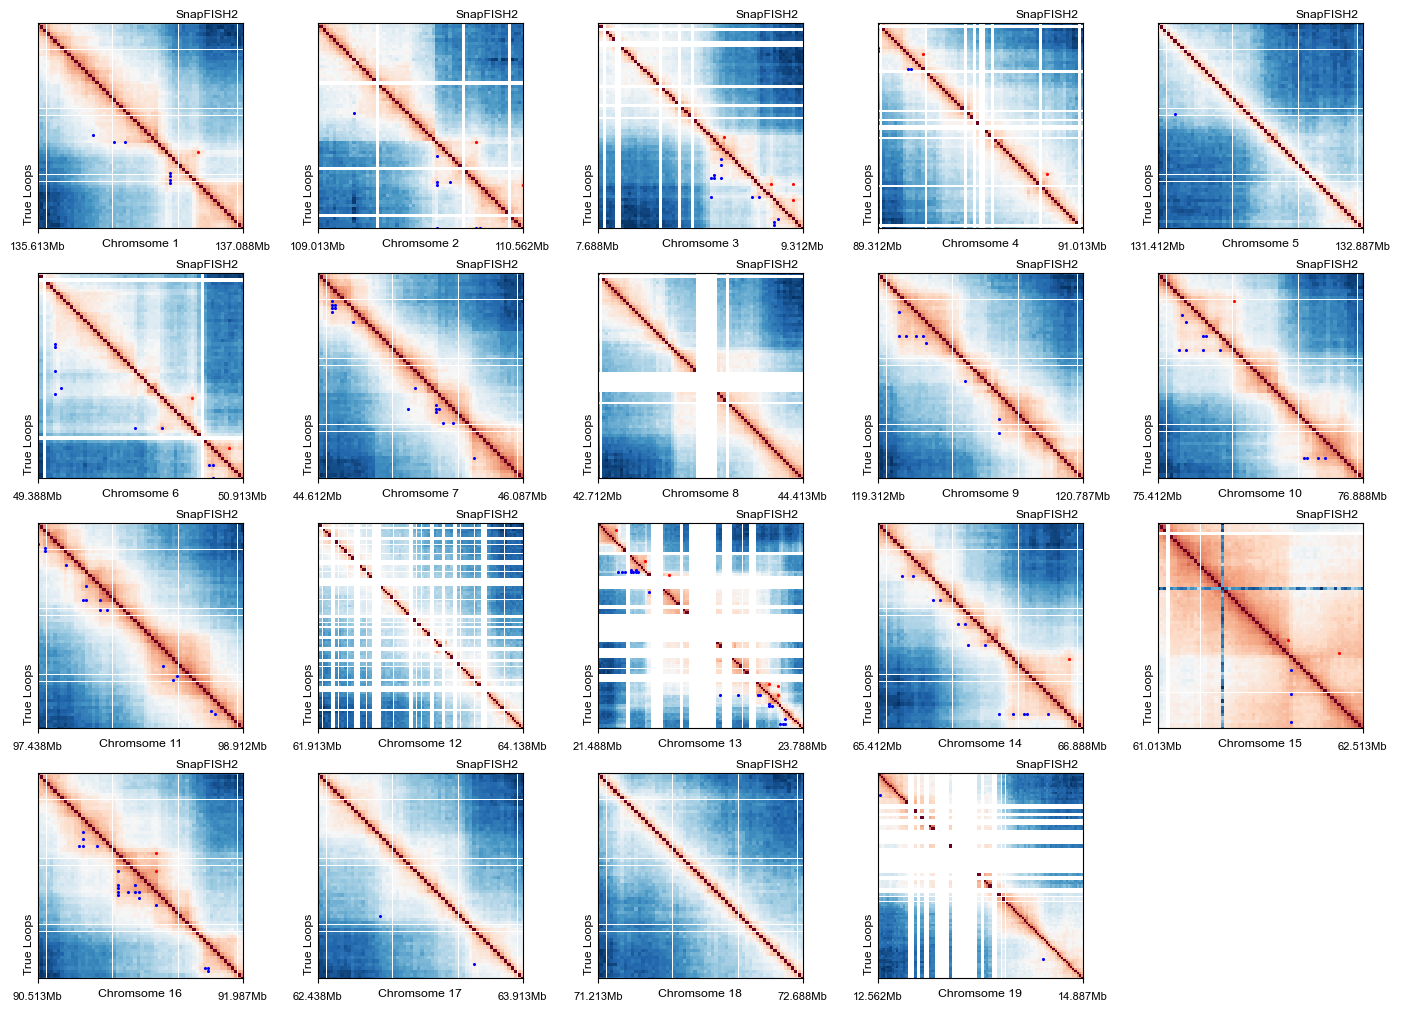

In [29]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i == 19:
        ax.axis("off")
        continue
    adata = loader.create_adata(f"chr{i+1}")
    med_dist = sf.pp.median_pdist(adata, inplace=False)
    d1d = adata.var.mean(axis=1).values
    x, y = list(map(lambda x: x.flatten(), np.meshgrid(d1d, d1d)))
    hm_df = pd.DataFrame({"x": x, "y": y, "dist": med_dist.flatten()})
    sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=ax,
                    palette="RdBu", s=6, marker="s", linewidth=0)
    ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
    sf.pl.compare_loops(res_sf2[res_sf2.final], common_loops, chr_id=f"chr{i+1}", 
                        map1="SnapFISH2", map2="True Loops", ax=ax)
    ax.get_legend().remove()
    ax.set(xlabel=f"Chromsome {i+1}")
fig.savefig(os.path.join(out_dire, "loop_sf2_all.pdf"), bbox_inches="tight")

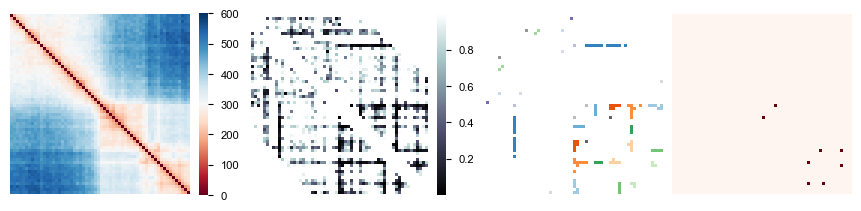

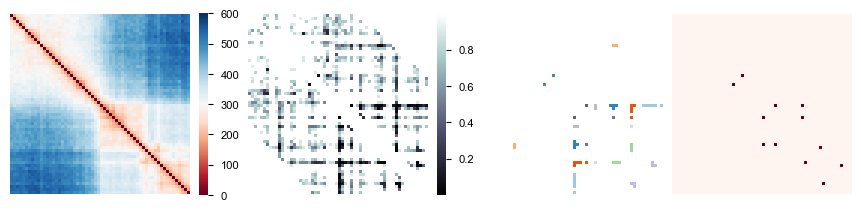

In [88]:
adata = loader.create_adata("chr3")
res = sf.tl.LoopCaller().call_loops(adata)
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adata, False), ax=axes[0], vmax=600)
sf.pl.pairwise_heatmap(res["fdr"], ax=axes[1], cmap="bone")
sf.pl.pairwise_heatmap(res["label"], ax=axes[2], cmap="tab20c", cbar=False)
loops = np.where(res["pval"] < 1e-5, res["summit"], 0)
sf.pl.pairwise_heatmap(loops, ax=axes[3], cmap="Reds", cbar=False)

res = sf.tl.LoopCaller(pval_cutoff=1, ltclass=sf.tl.TwoSampleT).call_loops(adata)
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adata, False), ax=axes[0], vmax=600)
sf.pl.pairwise_heatmap(res["fdr"], ax=axes[1], cmap="bone")
sf.pl.pairwise_heatmap(res["label"], ax=axes[2], cmap="tab20c", cbar=False)
sf.pl.pairwise_heatmap(res["final"], ax=axes[3], cmap="Reds", cbar=False)

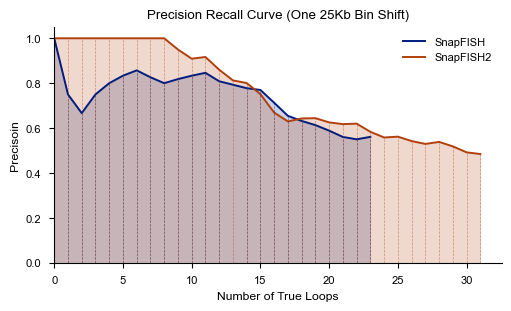

In [166]:
from utils.utils import precision_recall_res
fig, ax = plt.subplots(figsize=(5, 3))
df1 = precision_recall_res(res_sf1[res_sf1["c1"]!="chrX"], common_loops, 0)
df1["Method"] = "SnapFISH"
df2 = precision_recall_res(res_sf2[res_sf2["c1"]!="chrX"], common_loops, 0)
df2["Method"] = "SnapFISH2"
sns.lineplot(pd.concat([df1, df2]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "SnapFISH2": c2}, errorbar=None, ax=ax)

x, y = ax.lines[0].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c1, alpha=0.2)
ax.vlines(x, 0, y, color=c1, alpha=0.5, linewidth=0.5, linestyle="--")

x, y = ax.lines[1].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c2, alpha=0.2)
ax.vlines(x, 0, y, color=c2, alpha=0.5, linewidth=0.5, linestyle="--")

ax.set(xlim=(-.03, ax.get_xlim()[1]), ylim=(0, 1.05))
ax.set(xlabel="Number of True Loops", 
       title="Precision Recall Curve (One 25Kb Bin Shift)")
ax.legend(loc="upper right")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_prc_onebin.pdf"), bbox_inches="tight")

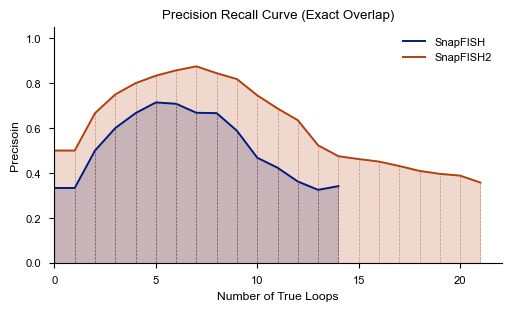

In [168]:
fig, ax = plt.subplots(figsize=(5, 3))
df1 = precision_recall_res(res_sf1[res_sf1["c1"]!="chrX"], common_loops, -1)
df1["Method"] = "SnapFISH"
df2 = precision_recall_res(res_sf2[res_sf2["c1"]!="chrX"], common_loops, -1)
df2["Method"] = "SnapFISH2"
sns.lineplot(pd.concat([df1, df2]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "SnapFISH2": c2}, errorbar=None, ax=ax)

x, y = ax.lines[0].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c1, alpha=0.2)
ax.vlines(x, 0, y, color=c1, alpha=0.5, linewidth=0.5, linestyle="--")

x, y = ax.lines[1].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c2, alpha=0.2)
ax.vlines(x, 0, y, color=c2, alpha=0.5, linewidth=0.5, linestyle="--")

ax.set(xlim=(-.03, ax.get_xlim()[1]), ylim=(0, 1.05))
ax.set(xticks=np.arange(0, 21, 5))
ax.set(xlabel="Number of True Loops", 
       title="Precision Recall Curve (Exact Overlap)")
ax.legend(loc="upper right")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_prc_exact.pdf"), bbox_inches="tight")

In [176]:
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
res_sf1_final, res_sf2_final = res_sf1[res_sf1.final], res_sf2[res_sf2.final]
shared = pd.merge(res_sf2_final, res_sf1_final[cols], how="inner", on=cols)
res_sf2_specific = pd.concat([res_sf2_final, shared]).drop_duplicates(cols, keep=False)

overlapped = sf.tl.loop_overlap(res_sf2_final, common_loops, -1)
overlapped = overlapped[overlapped["overlapped"]==3]
len(overlapped)/len(res_sf2_final)

0.4117647058823529

In [377]:
loop_pval1 = pd.merge(common_loops, res_sf1, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval1["type"] = "SnapFISH Loop"
null_pval1 = res_sf1.drop(loop_pval1.index)
null_pval1 = null_pval1[null_pval1.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval1["type"] = "SnapFISH Null"
loop_pval2 = pd.merge(common_loops, res_sf2, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval2["type"] = "SnapFISH2 Loop"
null_pval2 = res_sf2.drop(loop_pval2.index)
null_pval2 = null_pval2[null_pval2.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval2["type"] = "SnapFISH2 Null"

In [104]:
pvals = np.vstack([null_pval1.pval.values, null_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="less")

WilcoxonResult(statistic=129793422.0, pvalue=6.48460136105074e-30)

In [105]:
pvals = np.vstack([loop_pval1.pval.values, loop_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="greater")

WilcoxonResult(statistic=8519.0, pvalue=8.429895618819379e-07)

In [378]:
plt_df = pd.concat([loop_pval1, null_pval1, loop_pval2, null_pval2])
# +1e-20 to avoid log10(0)
plt_df["log10pval"] = np.log10(plt_df["pval"]+1e-20)
plt_df = plt_df[["log10pval", "type"]].dropna()

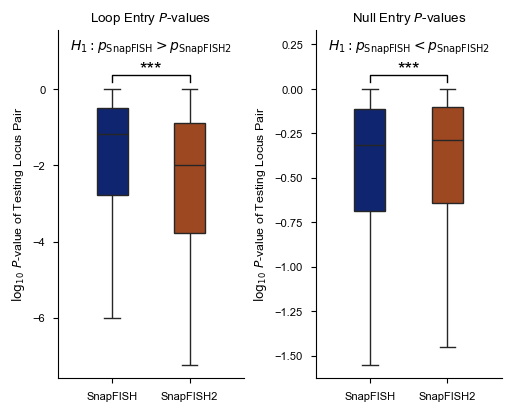

In [430]:
fig, axes = plt.subplots(1, 2, figsize=(5, 4))
plt_df["side"] = plt_df["type"].str.replace("^.*\\s", "", regex=True)
plt_df["test"] = plt_df["type"].str.replace("\\s.*$", "", regex=True)
palette = {"SnapFISH": c1, "SnapFISH2": c2}

for ax, side in zip(axes, ["Loop", "Null"]):
    df = plt_df[plt_df["side"] == side]
    sns.boxplot(df, y="log10pval", x="test", hue="test", palette=palette,
                showfliers=False, width=.4, legend=False, ax=ax)
    ax.grid(False)
    ax.set(xlabel=None, ylabel=r"$\log_{10}\,P$-value of Testing Locus Pair")
    ax.set_title(rf"{side} Entry $P$-values")
    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax.set(ylim=(ax.get_ylim()[0], ax.get_ylim()[1] + yrange * .15), xlim=(-.7, 1.7))
    
    h = (ax.get_ylim()[1] - ax.get_ylim()[0])*.02
    ax.plot([0, 0, 1, 1], [h, 2*h, 2*h, h], color="k", lw=1)
    ax.text(.5, 2*h, "***", ha="center", fontsize=14)
    ax.text(.5, 6*h, 
            fr"$H_1: p_{{\text{{SnapFISH}}}} {{{'>' if side == 'Loop' else '<'}}} p_{{\text{{SnapFISH2}}}}$", 
            va="center", ha="center")
fig.savefig(os.path.join(out_dire, "loop_pval.pdf"), bbox_inches="tight")

## Sox2 Chromatin Tracing

In [30]:
adatas_5kb = {}
for key in ["between", "downstream", "between_mutant"]:
    adatas_5kb[key] = sf.pp.FOF_CT_Loader(dtree["huang_ng_2021", key]).create_adata("chr3")
    allele = adatas_5kb[key].obs.index.str.replace(r"^.*_", "", regex=True)
    adatas_5kb[key].obs["allele"] = allele

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


In [31]:
from itertools import product
res = []
for key, allele in product(adatas_5kb, ["129", "CAST"]):
    a = adatas_5kb[key]
    m = np.mean(np.isnan(a[a.obs["allele"]==allele].layers["X"]), axis=0)
    df = pd.Series(m).to_frame("frac")
    df["key"] = key
    df["allele"] = allele
    df["var"] = a.var.index
    res.append(df)
res = pd.concat(res, ignore_index=True)

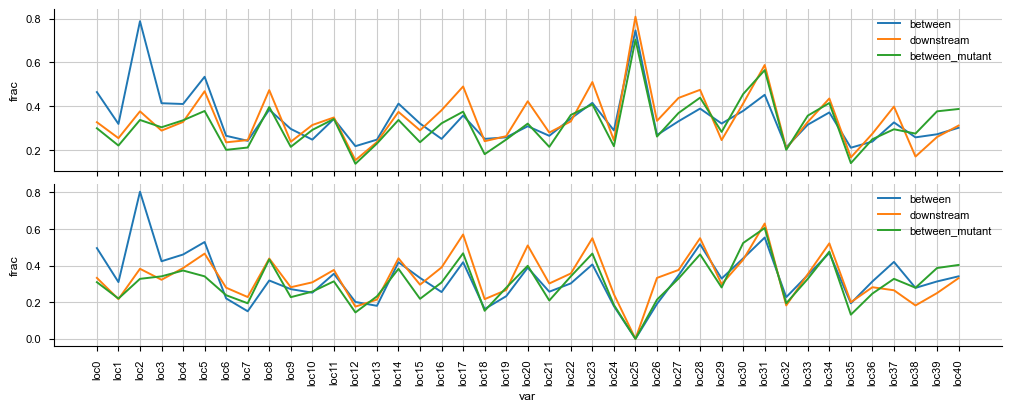

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
sns.lineplot(res[res["allele"]=="129"], x="var", y="frac", hue="key", ax=axes[0])
axes[0].legend(loc="upper right")
sns.lineplot(res[res["allele"]=="CAST"], x="var", y="frac", hue="key", ax=axes[1])
axes[1].legend(loc="upper right")
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show()

In [33]:
for k, v in adatas_5kb.items():
    for c in "XYZ":
        v.layers[c][:,25] = np.nan

In [34]:
from itertools import product
res = []
for key, allele in product(adatas_5kb, ["129", "CAST"]):
    a = adatas_5kb[key]
    m = np.mean(np.isnan(a[a.obs["allele"]==allele].layers["X"]), axis=0)
    df = pd.Series(m).to_frame("frac")
    df["key"] = key
    df["allele"] = allele
    df["var"] = a.var.index
    res.append(df)
res = pd.concat(res, ignore_index=True)

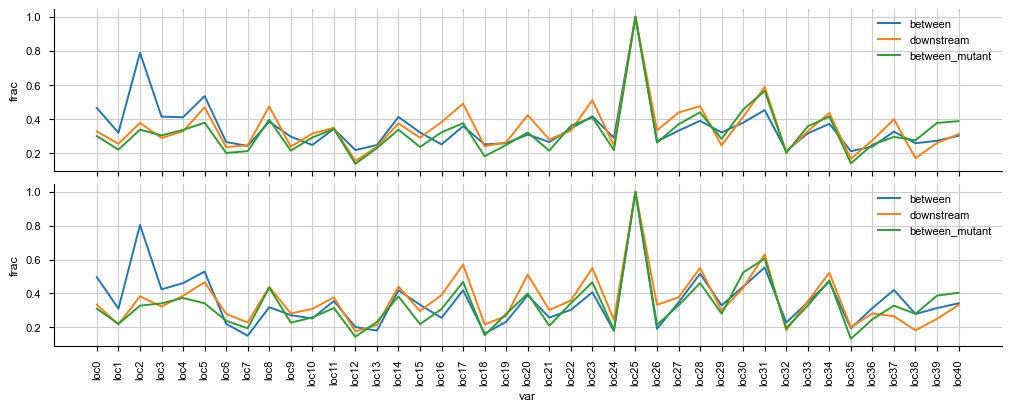

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
sns.lineplot(res[res["allele"]=="129"], x="var", y="frac", hue="key", ax=axes[0])
axes[0].legend(loc="upper right")
sns.lineplot(res[res["allele"]=="CAST"], x="var", y="frac", hue="key", ax=axes[1])
axes[1].legend(loc="upper right")
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show()

In [63]:
cast = adatas_5kb["between"][adatas_5kb["between"].obs["allele"]=="CAST"].copy()
c129 = adatas_5kb["between"][adatas_5kb["between"].obs["allele"]=="129"].copy()

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_69030/2257853151.py:4: RuntimeWarning: All-NaN slice encountered
  for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):


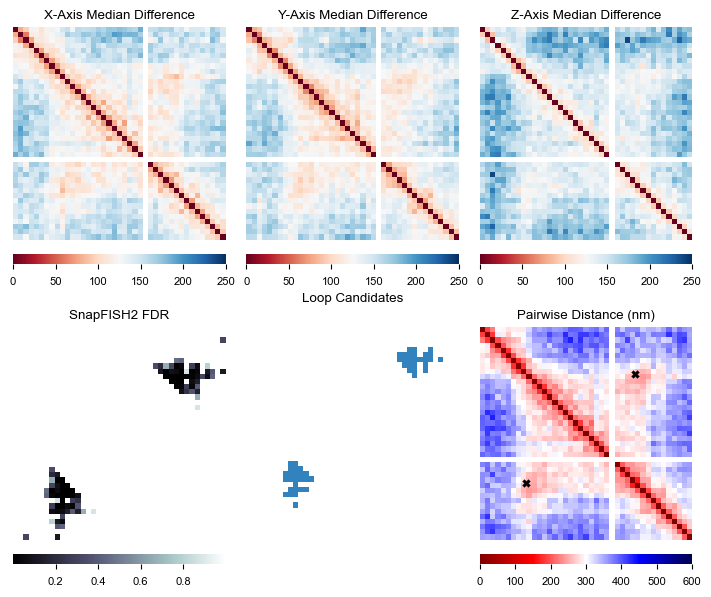

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(7, 6))
X = np.stack([c129.layers[c] for c in "XYZ"])
arr = X[:,:,None,:] - X[:,:,:,None]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
    sf.pl.pairwise_heatmap(mat, ax=axes.flat[i], vmax=250, 
                           title=f"{'XYZ'[i]}-Axis Median Difference", 
                           cbar_kws={"orientation": "horizontal"})
res = sf.tl.LoopCaller().call_loops(c129)
sf.pl.pairwise_heatmap(res["fdr"], title="SnapFISH2 FDR", ax=axes[1,0], cmap="bone", 
                       cbar_kws={"ticks": np.linspace(0, 1, 6), "orientation": "horizontal"})
sf.pl.pairwise_heatmap(res["label"], title="Loop Candidates", 
                       ax=axes[1,1], cmap="tab20c", cbar=False)
med_dist = sf.pp.median_pdist(c129, False)
sf.pl.pairwise_heatmap(med_dist, title="Pairwise Distance (nm)", ax=axes[1,2], 
                       vmax=600, cmap="seismic_r", cbar_kws={"orientation": "horizontal"})
axes[1,2].scatter(*np.where(res["summit"]), color="k", marker="X")
fig.savefig(os.path.join(out_dire, "loop_calling_129.pdf"), bbox_inches="tight")

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_69030/2227608762.py:4: RuntimeWarning: All-NaN slice encountered
  for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  xvars = np.nanmean(np.square(x0), axis=0)


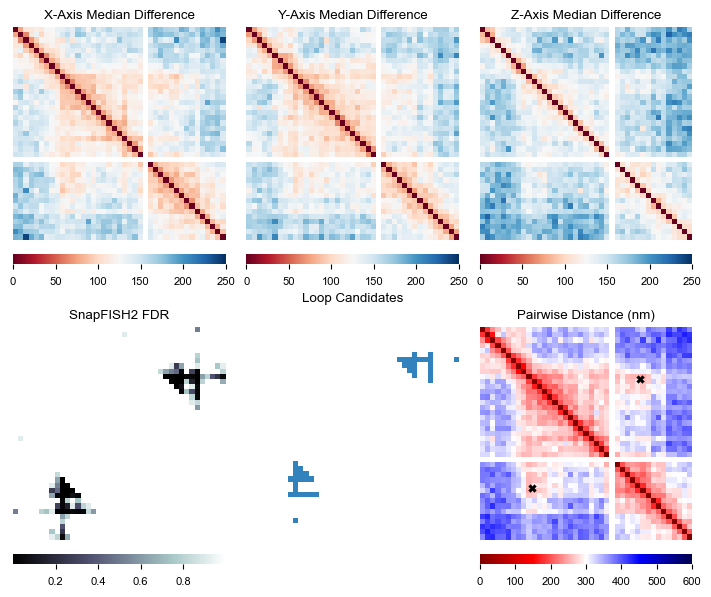

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(7, 6))
X = np.stack([cast.layers[c] for c in "XYZ"])
arr = X[:,:,None,:] - X[:,:,:,None]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
    sf.pl.pairwise_heatmap(mat, ax=axes.flat[i], vmax=250, 
                           title=f"{'XYZ'[i]}-Axis Median Difference", 
                           cbar_kws={"orientation": "horizontal"})
res = sf.tl.LoopCaller().call_loops(cast)
sf.pl.pairwise_heatmap(res["fdr"], title="SnapFISH2 FDR", ax=axes[1,0], cmap="bone", 
                       cbar_kws={"ticks": np.linspace(0, 1, 6), "orientation": "horizontal"})
sf.pl.pairwise_heatmap(res["label"], title="Loop Candidates", 
                       ax=axes[1,1], cmap="tab20c", cbar=False)
med_dist = sf.pp.median_pdist(cast, False)
sf.pl.pairwise_heatmap(med_dist, title="Pairwise Distance (nm)", ax=axes[1,2], 
                       vmax=600, cmap="seismic_r", cbar_kws={"orientation": "horizontal"})
axes[1,2].scatter(*np.where(res["summit"]), color="k", marker="X")
fig.savefig(os.path.join(out_dire, "loop_calling_cast.pdf"), bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4.5))
caller2 = sf.tl.LoopCaller(pval_cutoff=1e-5, gap=50e3, ltclass=sf.tl.AxisWiseF)
caller2.call_loops(adatas_5kb["between"], inplace=False)

In [434]:
igv_tracks = [{"name": "HiCExplorer", "url": hicexpl_path, 
               "format": "bedpe", "height": 50, "color": "red"}]
k = "between"
adata = adatas_5kb[k]
for allele in ["129", "CAST"]:
    caller2 = sf.tl.LoopCaller()
    a = adata[adata.obs["allele"]==allele].copy()
    res2 = caller2.to_bedpe(caller2.call_loops(a), a)
    f = os.path.join(out_dire, f"loop_result_{k}_{allele}.bedpe")
    res2[res2.final].iloc[:,:6].to_csv(f, sep="\t", index=False, header=False)
    print(k, allele, res2[res2.final]["pval"])
    igv_tracks.append({
        "name": f"{k} {allele}", "url": f, 
        "format": "bedpe", "height": 50
    })

between 129 344    9.542038e-09
Name: pval, dtype: float64
between CAST 375    7.171926e-08
Name: pval, dtype: float64


In [436]:
adata.shape[0]/2

571.0

In [263]:
dtree["chipseq_mesc", "H3K4me3", "bigWig"]

'../data/chipseq_mesc/ENCFF699IRY.bigWig'

In [ ]:
chr3:34,630,000-34,770,000

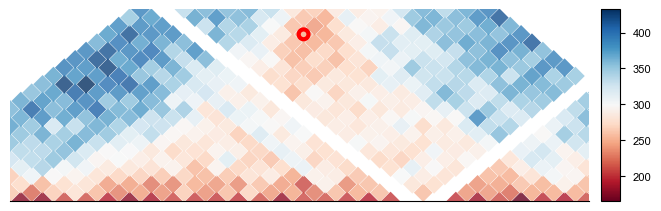

In [356]:
adata = adatas_5kb["between"]
mat = sf.tl.median_pdist(adata[adata.obs["allele"]=="129"], False)
fig = plt.figure(figsize=(6.5, 2))
fig, ax, cbar = sf.pl.triangle_heatmap(mat, adata.var, fig=fig, cut_hi=120e3, s=90, marker="D")

plot_range = (34_630_000, 34_770_000)
X = np.array([adata.var.Chrom_Start.min(), adata.var.Chrom_End.max()])
X = np.vstack([np.ones(2), X]).T
beta = np.linalg.inv(X.T@X)@X.T@ax.get_xticks()
new_xlim = np.vstack([np.ones(2), plot_range]).T@beta

f = os.path.join(out_dire, f"loop_result_between_129.bedpe")
f = pd.read_csv(f, sep="\t", header=None)
f.columns = ["c1", "s1", "e1", "c2", "s2", "e2"]
f["x"] = (f["s1"] + f["e1"]) / 2
f["y"] = (f["s2"] + f["e2"]) / 2
sf.pl.rotate_df(f)

sns.scatterplot(f, x="x_rot", y="y_rot", s=50, facecolors="none", edgecolors="r", linewidth=3, ax=ax)
ax.legend().remove()

ax.set(xlim=new_xlim, xlabel=None)
fig.savefig(os.path.join(out_dire, "loop_heatmap_between_129.pdf"), bbox_inches="tight")